In [1]:
import sys
!{sys.executable} -m pip install --user tf-nightly==2.15.0.dev20230812
!{sys.executable} -m pip install --user pandas
!{sys.executable} -m pip install --user numpy
!{sys.executable} -m pip install --user matplotlib
!{sys.executable} -m pip install --user scikit-learn

You should consider upgrading via the 'c:\Users\pdude\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\pdude\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\pdude\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\pdude\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0


ERROR: Could not install packages due to an OSError: [WinError 5] Odmowa dostępu: 'C:\\Users\\pdude\\AppData\\Roaming\\Python\\Python39\\site-packages\\~umpy.libs\\libopenblas64__v0.3.23-293-gc2f4bdbb-gcc_10_3_0-65e29aac85b9409a6008e2dc84b1cc09.dll'
Check the permissions.

You should consider upgrading via the 'c:\Users\pdude\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
tf.__version__

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


'2.15.0-dev20230812'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ploting.utlis as pltu

In [4]:
run_path = "./models/lstm_3d_14d_ngorup_ylog/r20230916_181513"

In [5]:
def normalize_types(df):
    for column in df.columns[df.dtypes == 'float64']:
        df[column] = df[column].astype(np.float32)

id = 1
X_train = pd.read_csv(f'./data/X_train_{id}.csv', dtype=np.float32).values
X_val = pd.read_csv(f'./data/X_val_{id}.csv', dtype=np.float32).values
X_test = pd.read_csv(f'./data/X_test_{id}.csv', dtype=np.float32).values

# X_train_ae = pickle.load(open(f'./data/x_train_ae_{id}.pkl', 'rb'))
# X_val_ae = pickle.load(open(f'./data/x_val_ae_{id}.pkl', 'rb'))
# X_test_ae = pickle.load(open(f'./data/x_test_ae_{id}.pkl', 'rb'))

y_train = pd.read_csv(f'./data/y_train_{id}.csv', dtype=np.float32).values
y_val = pd.read_csv(f'./data/y_val_{id}.csv', dtype=np.float32).values
y_test = pd.read_csv(f'./data/y_test_{id}.csv', dtype=np.float32).values

ypm_train = pd.read_csv(f'./data/y_train_{id}.csv', dtype=np.float32).values * 1000
ypm_val = pd.read_csv(f'./data/y_val_{id}.csv', dtype=np.float32).values * 1000
ypm_test = pd.read_csv(f'./data/y_test_{id}.csv', dtype=np.float32).values * 1000

ids_train = pd.read_csv(f'./data/ids_train_{id}.csv').values
ids_val = pd.read_csv(f'./data/ids_val_{id}.csv').values
ids_test = pd.read_csv(f'./data/ids_test_{id}.csv').values

buildings_train = pd.read_csv(f'./data/buildings_train_{id}.csv').values
buildings_val = pd.read_csv(f'./data/buildings_val_{id}.csv').values
buildings_test = pd.read_csv(f'./data/buildings_test_{id}.csv').values

print('train', buildings_train.shape, X_train.shape, y_train.shape, ids_train.shape)
print('val', buildings_val.shape, X_val.shape, y_val.shape, ids_val.shape)
print('test', buildings_test.shape, X_test.shape, y_test.shape, ids_test.shape)

train (302, 1) (2111783, 132) (2111783, 1) (2111783, 2)
val (101, 1) (718535, 132) (718535, 1) (718535, 2)
test (101, 1) (683495, 132) (683495, 1) (683495, 2)


In [6]:
ylog_train = np.log(ypm_train) 
ylog_test = np.log(ypm_test)
ylog_val = np.log(ypm_val)

In [7]:
def create_sequences(X, y, ids, buildings, time_steps=14, time_steps_out=3, group=False):
    X_output = []
    y_output = []

    for building in buildings:
        if not group and '_grp' in building[0]:
            continue
        
        X_values = X[ids[:,1] == building]
        y_values = y[ids[:,1] == building]

        time_steps_in_hours = time_steps * 24
        _time_steps = time_steps
        _time_steps_out = time_steps_out

        if('_grp' not in building[0]):
            _time_steps = _time_steps * 24
            _time_steps_out = _time_steps_out * 24

        for i in range(len(X_values) - _time_steps + 1):
            if len(y_values) <= (i + _time_steps_out + 1):
                continue
            _X = X_values[i : (i + _time_steps)]
            _X = np.pad(_X.reshape(-1), (0, time_steps_in_hours - _time_steps), 'constant').reshape(-1, 1)
            X_output.append(_X)
            y_output.append(np.sum(y_values[i+1:i+_time_steps_out+1]))

    return np.stack(X_output), np.array(y_output).reshape(-1, 1)

In [8]:
import json

history = None
with open(f'{run_path}/history.json') as history_file:
    history = json.load(history_file)
params = None
with open(f'{run_path}/params.json') as params_file:
    params = json.load(params_file)

In [ ]:
# from tensorflow import keras
# from tensorflow.keras import Sequential
# from tensorflow.keras import layers
# from tensorflow.keras import metrics
# from tensorflow.keras import callbacks
# from tensorflow.keras import regularizers

# def max_absolute_error(y_true, y_pred):
#     return tf.keras.backend.max(tf.keras.backend.abs(y_true - y_pred))

# model = keras.models.load_model(f'{run_path}/model.keras', custom_objects={'max_absolute_error': max_absolute_error})

ValueError: Layer 'lstm_cell' expected 3 variables, but received 0 variables during loading. Expected: ['lstm_5/lstm_cell/kernel:0', 'lstm_5/lstm_cell/recurrent_kernel:0', 'lstm_5/lstm_cell/bias:0']

In [10]:
X_train_seq, y_train_seq = create_sequences(ylog_train[:], ypm_train[:], ids_train[:], buildings_train[:], params['time_step'], params['time_step_out'], group=params['group'])
X_val_seq, y_val_seq = create_sequences(ylog_val[:], ypm_val[:], ids_val[:], buildings_val[:], params['time_step'], params['time_step_out'], group=params['group'])
X_test_seq, y_test_seq = create_sequences(ylog_test[:], ypm_test[:], ids_test[:], buildings_test[:], params['time_step'], params['time_step_out'], group=params['group'])

print('train', X_train_seq.shape, y_train_seq.shape)
print('val', X_val_seq.shape, y_val_seq.shape)
print('test', X_test_seq.shape, y_test_seq.shape)

train (2022623, 336, 1) (2022623, 1)
val (682640, 336, 1) (682640, 1)
test (648940, 336, 1) (648940, 1)


In [11]:
dataset = {
    'X_train': X_train_seq,
    'X_val': X_val_seq,
    'X_test': X_test_seq,
    'y_train': y_train_seq,
    'y_val': y_val_seq,
    'y_test': y_test_seq,
}

In [12]:
metrics_lims = {
    'mse': 3200,
    'mae': 38,
    'mape': 100,
}
set_names = {
    'train': 'training',
    'val': 'validation',
    'test': 'test'
}
metrics_y_labels = {
    'mse': 'Mean Squared Error',
    'mae': 'Mean Absolute Error',
    'mape': 'Mean Absolute Percentage Error'
}
metrics_title = {
    'mse': 'mean squared error',
    'mae': 'mean absolute error',
    'mape': 'mean absolute percentage error'
}
title_sets_names = {
    'train': 'training',
    'val': 'validation',
    'test': 'test',
}
metrics_y_lims = {
    'mse': (1900, 3800),
    'mae': (28, 42),
    'mape': (0, 100)
}

def draw_plot_for_model(model_history, metric, title, y_range=None):
    plt.figure(figsize=(10,8))

    last_epoch = len(model_history[metric])
    epochs = range(1, last_epoch + 1)
    plt.plot(epochs, model_history[metric], 'b-', label='training set')
    plt.plot(epochs, model_history['val_' + metric], 'r-', label='validation set')

    plt.xlabel('Epoch number', fontsize=14)
    plt.xlim((1, last_epoch))
    plt.xticks(fontsize=14)
    plt.ylabel(metrics_y_labels[metric], fontsize=14)
    plt.yticks(fontsize=14)
    if y_range is not None:
        plt.ylim(y_range)
    plt.legend(fontsize=14)

    last_train_error = str(round(model_history[metric][-1], 3)).replace('.', ',')
    last_val_error = str(round(model_history['val_' + metric][-1], 3)).replace('.', ',')
    full_title = f'Value of {metrics_title[metric]} for the best model during training\nError value for training set in epoch {last_epoch}: {last_train_error}\nError value for validation set in epoch {last_epoch}: {last_val_error}'
    plt.title(full_title, fontsize=14, fontweight='bold')

    plt.show()

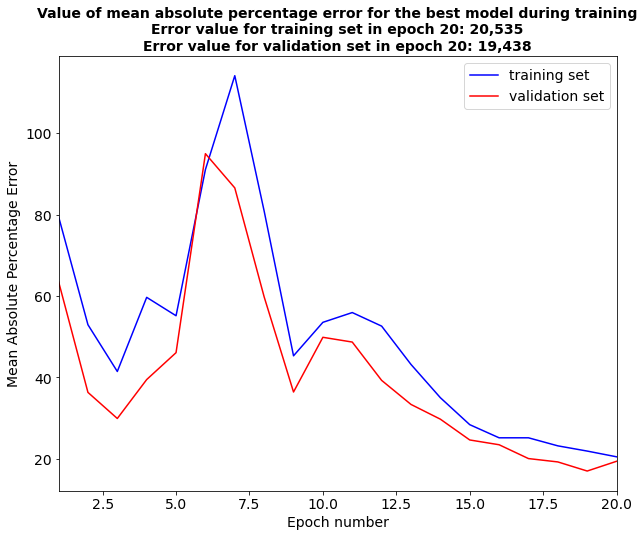

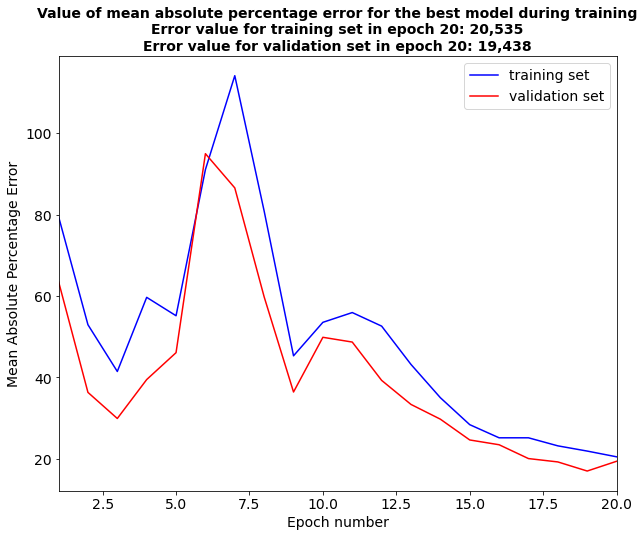

In [13]:
draw_plot_for_model(history['history'], 'mape', '')
draw_plot_for_model(history['history'], 'mape', '')

In [14]:
y_train_pred = model.predict(X_train_seq)
y_val_pred = model.predict(X_val_seq)
y_test_pred = model.predict(X_test_seq)

NameError: name 'model' is not defined

In [ ]:
e_train = y_train_pred.reshape(-1) - y_train_seq.reshape(-1)
e_val = y_val_pred.reshape(-1) - y_val_seq.reshape(-1)
e_test = y_test_pred.reshape(-1) - y_test_seq.reshape(-1)

In [ ]:
ae_train = np.abs(e_train)
ae_val = np.abs(e_val)
ae_test = np.abs(e_test)

In [ ]:
re_train = ae_train / np.abs(y_train_seq.reshape(-1))
re_val = ae_val / np.abs(y_val_seq.reshape(-1))
re_test = ae_test / np.abs(y_test_seq.reshape(-1))

In [ ]:
from math import trunc

def truncate(value, decimals=4):
    factor = 10.0 ** decimals
    return trunc(value * factor) / factor

def draw_hist(e_train, e_val, e_test, bins, xlabel, error_name_for_title, percentile=(0, 100), show_zero_line=True):
    e_all = np.concatenate((e_train, e_val, e_test))
    lower_perc = percentile[0]
    upper_perc = percentile[1]
    e_from = np.percentile(e_all, lower_perc)
    e_to = np.percentile(e_all, upper_perc)

    e_train = e_train[(e_train >= e_from) & (e_train <= e_to)]
    e_val = e_val[(e_val >= e_from) & (e_val <= e_to)]
    e_test = e_test[(e_test >= e_from) & (e_test <= e_to)]

    values_range = (np.min([np.min(e_train), np.min(e_val), np.min(e_test)]), np.max([np.max(e_train), np.max(e_val), np.max(e_test)]))

    heights_train, all_bins = np.histogram(e_train, bins=bins, range=values_range)
    heights_val, _ = np.histogram(e_val, bins=bins, range=values_range)
    heights_test, _ = np.histogram(e_test, bins=bins, range=values_range)

    df_hist = pd.DataFrame(np.column_stack((all_bins[:-1], heights_train, heights_val, heights_test)), columns=['bins', 'train_count', 'val_count', 'test_count'])
    df_hist['all_count'] = df_hist['train_count'] + df_hist['val_count'] + df_hist['test_count']
    df_hist['train_prop'] = df_hist['train_count'] / df_hist['all_count'].sum()
    df_hist['val_prop'] = df_hist['val_count'] / df_hist['all_count'].sum()
    df_hist['test_prop'] = df_hist['test_count'] / df_hist['all_count'].sum()
    df_hist['all_prop'] = df_hist['all_count'] / df_hist['all_count'].sum()

    width = df_hist['bins'][1] - df_hist['bins'][0]

    plt.figure(figsize=(10,8))

    title = f'Histogram with {str(bins)} bins for obtained {error_name_for_title}'
    data_perc = upper_perc - lower_perc
    if data_perc < 100:
        lower_title = f'from {pltu.format_float(lower_perc, 1)} percentile ' if lower_perc > 0 else ''
        title += f'\nin the range {lower_title}to {pltu.format_float(upper_perc, 1)} percentile ({data_perc}% of measurements)'
    plt.title(title, fontsize=14, fontweight='bold')

    plt.bar(df_hist['bins'], df_hist['train_prop'], width=width, align='edge', color='blue', edgecolor='dimgray', label='training set')
    plt.bar(df_hist['bins'], df_hist['val_prop'], bottom=df_hist['train_prop'], width=width, align='edge', color='red', label='validation set', edgecolor='dimgray')
    plt.bar(df_hist['bins'], df_hist['test_prop'], bottom=np.array(df_hist['train_prop']) + np.array(df_hist['val_prop']), width=width, align='edge', color='lightgreen', label='test set', edgecolor='dimgray')
    if show_zero_line:
        plt.axvline(x=0, label='zero error', color='orange', linewidth=3)

    plt.xlabel(xlabel, fontsize=16)
    plt.xticks(
        all_bins,
        labels=[pltu.format_float(bin, 3) for bin in all_bins], 
        rotation=90, 
        fontsize=14)

    plt.ylabel('Frequency', fontsize=16)
    plt.yticks(fontsize=14)
    plt.ylim((0, df_hist['all_prop'].max() * 1.2))

    plt.legend(fontsize=14)

    shift_by = width / 2
    rotation = 90 if len(heights_train) > 10 else 0
    for bin, height in zip(df_hist['bins'], df_hist['all_prop']):
        if height == 0:
            continue;
        
        rounded_height = truncate(height, 4)
        text = '<0.0001' if rounded_height == 0 else str(rounded_height).replace('.', ',')
        fontsize = 10 if rounded_height == 0 else 12
        plt.annotate(text, (bin + shift_by, height), textcoords="offset points", va='bottom', ha='center', fontsize=fontsize, xytext=(0,5), rotation=rotation)

    plt.show()

    display(df_hist)

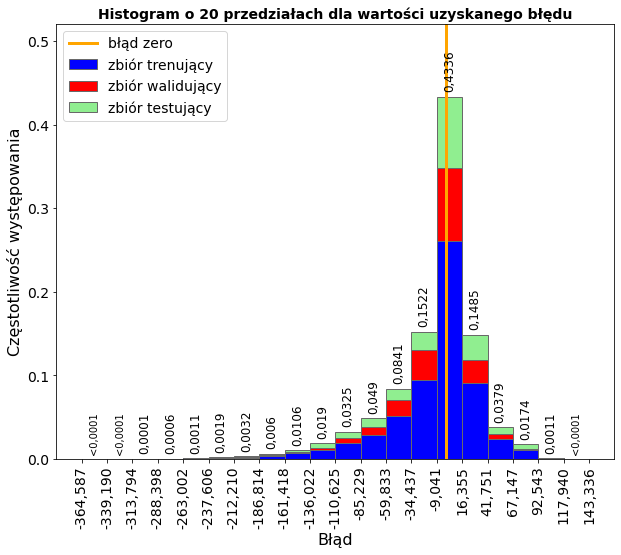

,bins,train_count,val_count,test_count,all_count,train_prop,val_prop,test_prop,all_prop
0,-364.586578,119.0,1.0,0.0,120.0,0.000031,2.595145e-07,0.000000e+00,0.000031
1,-339.190460,233.0,26.0,0.0,259.0,0.000060,6.747377e-06,0.000000e+00,0.000067
2,-313.794342,545.0,154.0,0.0,699.0,0.000141,3.996524e-05,0.000000e+00,0.000181
3,-288.398224,1686.0,558.0,75.0,2319.0,0.000438,1.448091e-04,1.946359e-05,0.000602
4,-263.002136,2569.0,1452.0,517.0,4538.0,0.000667,3.768151e-04,1.341690e-04,0.001178
5,-237.606018,3652.0,2516.0,1466.0,7634.0,0.000948,6.529385e-04,3.804483e-04,0.001981
6,-212.209900,6957.0,2966.0,2675.0,12598.0,0.001805,7.697201e-04,6.942013e-04,0.003269
7,-186.813782,14341.0,3415.0,5701.0,23457.0,0.003722,8.862421e-04,1.479492e-03,0.006087
8,-161.417664,26449.0,5093.0,9415.0,40957.0,0.006864,1.321707e-03,2.443329e-03,0.010629
9,-136.021561,43471.0,9186.0,20581.0,73238.0,0.011281,2.383900e-03,5.341068e-03,0.019006


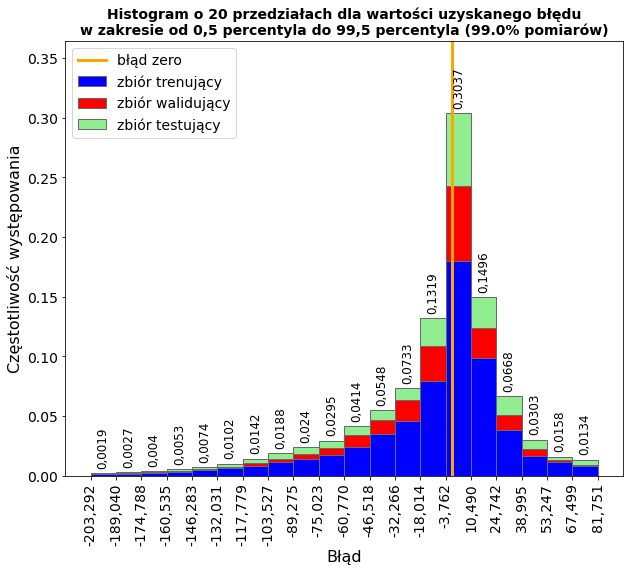

,bins,train_count,val_count,test_count,all_count,train_prop,val_prop,test_prop,all_prop
0,-203.291794,4212.0,1685.0,1641.0,7538.0,0.001104,0.000442,0.000430,0.001976
1,-189.039658,6372.0,1778.0,2443.0,10593.0,0.001670,0.000466,0.000640,0.002777
2,-174.787521,9514.0,2060.0,3836.0,15410.0,0.002494,0.000540,0.001006,0.004040
3,-160.535370,13107.0,2558.0,4592.0,20257.0,0.003436,0.000671,0.001204,0.005310
4,-146.283234,18109.0,3481.0,6776.0,28366.0,0.004747,0.000912,0.001776,0.007436
5,-132.031097,23424.0,4874.0,10985.0,39283.0,0.006140,0.001278,0.002880,0.010297
6,-117.778954,32272.0,7228.0,14845.0,54345.0,0.008460,0.001895,0.003891,0.014246
7,-103.526817,43676.0,11574.0,16652.0,71902.0,0.011449,0.003034,0.004365,0.018848
8,-89.274673,54240.0,16238.0,21435.0,91913.0,0.014218,0.004257,0.005619,0.024094
9,-75.022537,66771.0,22540.0,23295.0,112606.0,0.017503,0.005909,0.006106,0.029518


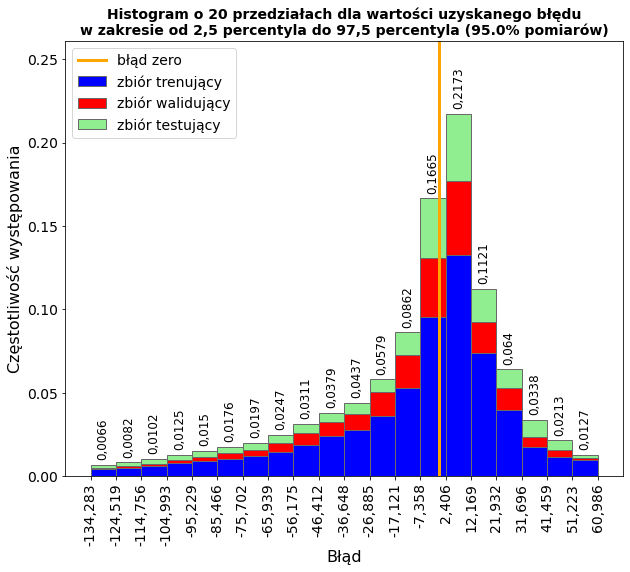

,bins,train_count,val_count,test_count,all_count,train_prop,val_prop,test_prop,all_prop
0,-134.282928,14729.0,3046.0,6520.0,24295.0,0.004024,0.000832,0.001781,0.006637
1,-124.519470,17611.0,3756.0,8871.0,30238.0,0.004811,0.001026,0.002423,0.008260
2,-114.756004,22435.0,5029.0,10174.0,37638.0,0.006129,0.001374,0.002779,0.010282
3,-104.992546,28478.0,7021.0,10558.0,46057.0,0.007779,0.001918,0.002884,0.012582
4,-95.229080,32482.0,9302.0,13295.0,55079.0,0.008873,0.002541,0.003632,0.015046
5,-85.465622,38150.0,11482.0,14854.0,64486.0,0.010422,0.003137,0.004058,0.017616
6,-75.702164,43443.0,14013.0,14995.0,72451.0,0.011867,0.003828,0.004096,0.019792
7,-65.938698,52379.0,19828.0,18358.0,90565.0,0.014309,0.005416,0.005015,0.024740
8,-56.175240,67245.0,28260.0,18500.0,114005.0,0.018370,0.007720,0.005054,0.031143
9,-46.411777,88279.0,29571.0,20918.0,138768.0,0.024115,0.008078,0.005714,0.037908


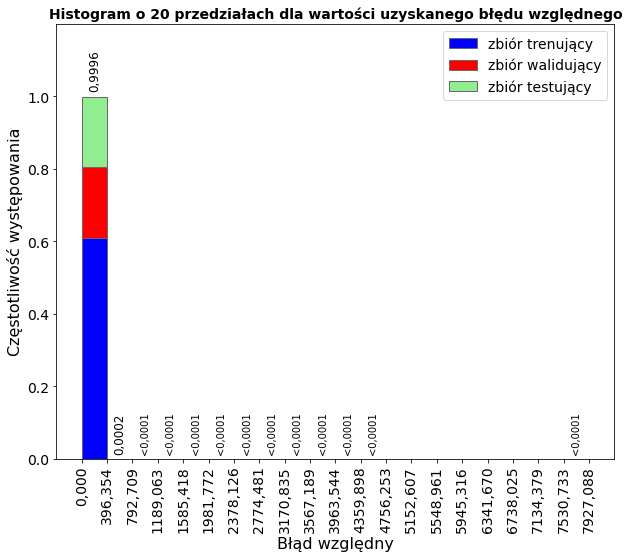

,bins,train_count,val_count,test_count,all_count,train_prop,val_prop,test_prop,all_prop
0,0.000000,2346077.0,761650.0,744168.0,3851895.0,6.088410e-01,0.197659,1.931224e-01,9.996227e-01
1,396.354401,577.0,89.0,154.0,820.0,1.497399e-04,0.000023,3.996524e-05,2.128019e-04
2,792.708801,71.0,82.0,23.0,176.0,1.842553e-05,0.000021,5.968834e-06,4.567455e-05
3,1189.063232,121.0,61.0,0.0,182.0,3.140126e-05,0.000016,0.000000e+00,4.723164e-05
4,1585.417603,106.0,18.0,30.0,154.0,2.750854e-05,0.000005,7.785435e-06,3.996524e-05
5,1981.771973,31.0,0.0,39.0,70.0,8.044950e-06,0.000000,1.012107e-05,1.816602e-05
6,2378.126465,2.0,0.0,20.0,22.0,5.190290e-07,0.000000,5.190290e-06,5.709319e-06
7,2774.480713,3.0,0.0,3.0,6.0,7.785435e-07,0.000000,7.785435e-07,1.557087e-06
8,3170.835205,12.0,0.0,0.0,12.0,3.114174e-06,0.000000,0.000000e+00,3.114174e-06
9,3567.189453,9.0,0.0,0.0,9.0,2.335631e-06,0.000000,0.000000e+00,2.335631e-06


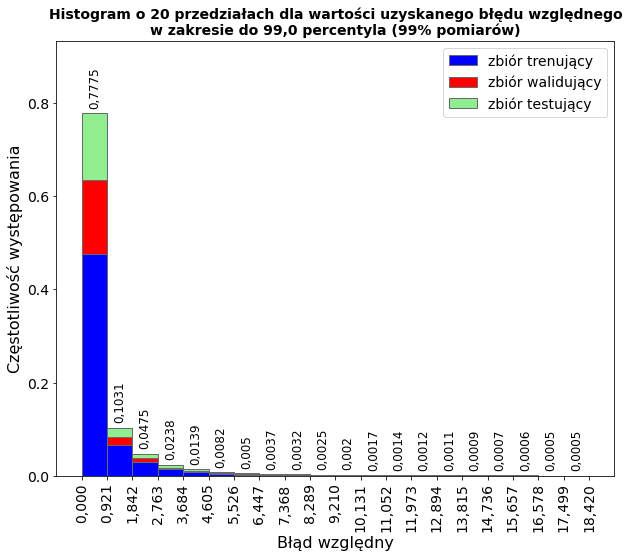

,bins,train_count,val_count,test_count,all_count,train_prop,val_prop,test_prop,all_prop
0,0.000000,1817523.0,605094.0,543508.0,2966125.0,0.476438,0.158617,0.142473,0.777528
1,0.921000,248680.0,68967.0,75709.0,393356.0,0.065188,0.018079,0.019846,0.103113
2,1.842000,113841.0,29011.0,38666.0,181518.0,0.029842,0.007605,0.010136,0.047582
3,2.763000,53020.0,13207.0,24750.0,90977.0,0.013898,0.003462,0.006488,0.023848
4,3.684001,29150.0,8105.0,15997.0,53252.0,0.007641,0.002125,0.004193,0.013959
5,4.605001,15877.0,5589.0,10018.0,31484.0,0.004162,0.001465,0.002626,0.008253
6,5.526001,9078.0,3782.0,6278.0,19138.0,0.002380,0.000991,0.001646,0.005017
7,6.447001,5840.0,3320.0,5124.0,14284.0,0.001531,0.000870,0.001343,0.003744
8,7.368001,3899.0,3888.0,4458.0,12245.0,0.001022,0.001019,0.001169,0.003210
9,8.289001,2698.0,3433.0,3508.0,9639.0,0.000707,0.000900,0.000920,0.002527


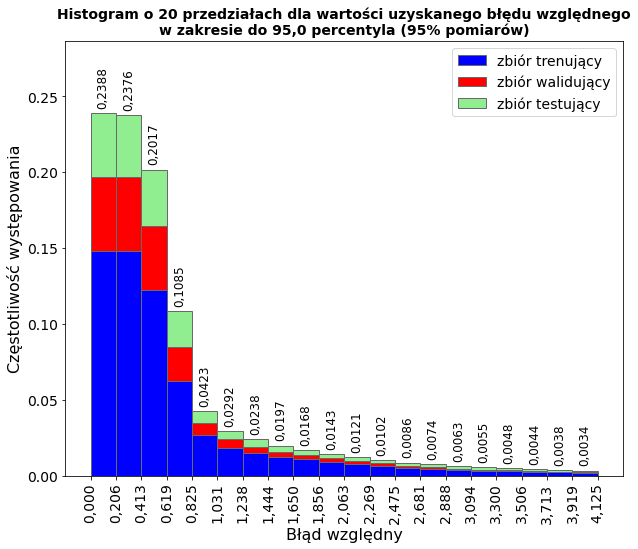

,bins,train_count,val_count,test_count,all_count,train_prop,val_prop,test_prop,all_prop
0,0.000000,541658.0,178856.0,153965.0,874479.0,0.147966,0.048859,0.042059,0.238884
1,0.206261,543157.0,176887.0,149922.0,869966.0,0.148376,0.048321,0.040955,0.237651
2,0.412521,448855.0,153103.0,136455.0,738413.0,0.122615,0.041824,0.037276,0.201715
3,0.618782,229542.0,79939.0,87924.0,397405.0,0.062705,0.021837,0.024018,0.108560
4,0.825042,97729.0,28835.0,28379.0,154943.0,0.026697,0.007877,0.007752,0.042326
5,1.031303,67885.0,19442.0,19605.0,106932.0,0.018544,0.005311,0.005356,0.029211
6,1.237563,54759.0,15290.0,17397.0,87446.0,0.014959,0.004177,0.004752,0.023888
7,1.443824,45801.0,12194.0,14168.0,72163.0,0.012512,0.003331,0.003870,0.019713
8,1.650085,39275.0,10226.0,12191.0,61692.0,0.010729,0.002793,0.003330,0.016853
9,1.856345,33497.0,8503.0,10364.0,52364.0,0.009150,0.002323,0.002831,0.014304


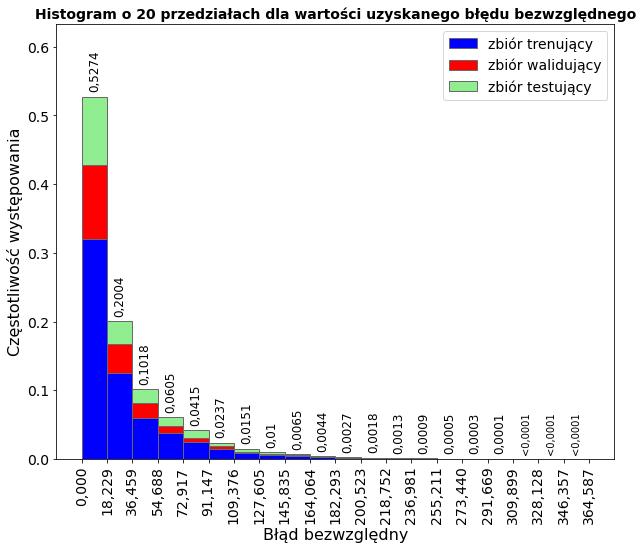

,bins,train_count,val_count,test_count,all_count,train_prop,val_prop,test_prop,all_prop
0,0.000000,1232857.0,412977.0,386741.0,2032575.0,0.319944,0.107174,0.100365,0.527483
1,18.229328,480323.0,163659.0,128434.0,772416.0,0.124651,0.042472,0.033330,0.200453
2,36.458656,231929.0,82882.0,77732.0,392543.0,0.060189,0.021509,0.020173,0.101871
3,54.687988,146167.0,39819.0,47497.0,233483.0,0.037932,0.010334,0.012326,0.060592
4,72.917313,96109.0,23282.0,40842.0,160233.0,0.024942,0.006042,0.010599,0.041583
5,91.146645,56630.0,13279.0,21517.0,91426.0,0.014696,0.003446,0.005584,0.023726
6,109.375977,34218.0,7343.0,16695.0,58256.0,0.008880,0.001906,0.004333,0.015118
7,127.605301,24353.0,4750.0,9477.0,38580.0,0.006320,0.001233,0.002459,0.010012
8,145.834625,16378.0,3204.0,5826.0,25408.0,0.004250,0.000831,0.001512,0.006594
9,164.063965,10372.0,2497.0,4256.0,17125.0,0.002692,0.000648,0.001104,0.004444


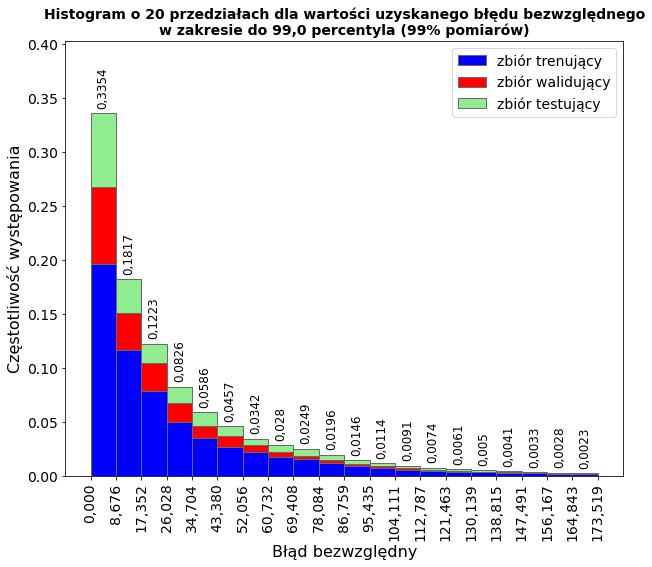

,bins,train_count,val_count,test_count,all_count,train_prop,val_prop,test_prop,all_prop
0,0.000000,748755.0,272551.0,258216.0,1279522.0,0.196276,0.071445,0.067688,0.335409
1,8.675947,445703.0,129175.0,118387.0,693265.0,0.116835,0.033861,0.031033,0.181730
2,17.351894,299999.0,97993.0,68939.0,466931.0,0.078641,0.025687,0.018071,0.122399
3,26.027843,189245.0,67194.0,58742.0,315181.0,0.049608,0.017614,0.015398,0.082620
4,34.703789,131856.0,42610.0,49431.0,223897.0,0.034564,0.011170,0.012958,0.058691
5,43.379738,101247.0,41012.0,32243.0,174502.0,0.026540,0.010751,0.008452,0.045743
6,52.055687,83316.0,25328.0,22185.0,130829.0,0.021840,0.006639,0.005815,0.034295
7,60.731632,66781.0,17713.0,22651.0,107145.0,0.017506,0.004643,0.005938,0.028087
8,69.407578,58251.0,13366.0,23440.0,95057.0,0.015270,0.003504,0.006144,0.024918
9,78.083527,44239.0,11011.0,19562.0,74812.0,0.011597,0.002886,0.005128,0.019611


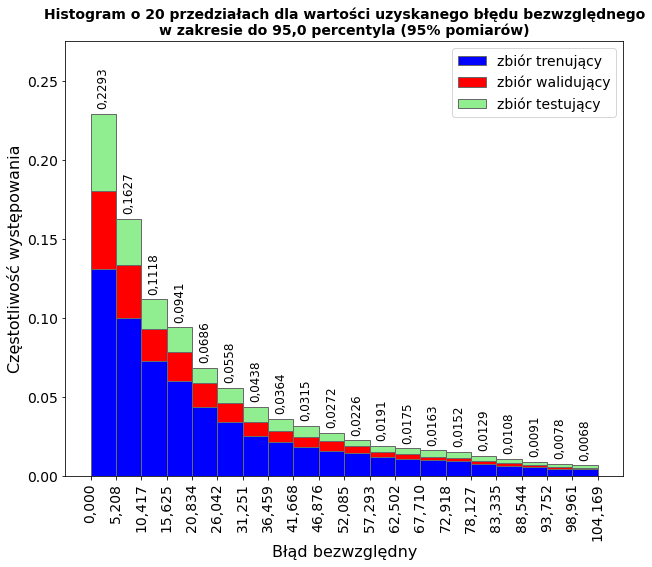

,bins,train_count,val_count,test_count,all_count,train_prop,val_prop,test_prop,all_prop
0,0.000000,479910.0,180027.0,179471.0,839408.0,0.131099,0.049179,0.049027,0.229304
1,5.208462,367409.0,122880.0,105520.0,595809.0,0.100366,0.033568,0.028825,0.162759
2,10.416924,265638.0,75715.0,67962.0,409315.0,0.072565,0.020683,0.018565,0.111814
3,15.625385,221073.0,66321.0,57082.0,344476.0,0.060391,0.018117,0.015593,0.094102
4,20.833847,160781.0,54909.0,35603.0,251293.0,0.043921,0.015000,0.009726,0.068647
5,26.042309,125766.0,43367.0,35142.0,204275.0,0.034356,0.011847,0.009600,0.055802
6,31.250771,92610.0,33422.0,34398.0,160430.0,0.025299,0.009130,0.009397,0.043825
7,36.459232,78895.0,24793.0,29735.0,133423.0,0.021552,0.006773,0.008123,0.036448
8,41.667694,66566.0,25084.0,23894.0,115544.0,0.018184,0.006852,0.006527,0.031564
9,46.876156,58481.0,24134.0,17221.0,99836.0,0.015975,0.006593,0.004704,0.027273


In [ ]:
draw_hist(e_train, e_val, e_test, 20, 'Error', 'error', (0, 100))
draw_hist(e_train, e_val, e_test, 20, 'Error', 'error', (0.5, 99.5))
draw_hist(e_train, e_val, e_test, 20, 'Error', 'error', (2.5, 97.5))

draw_hist(re_train, re_val, re_test, 20, 'Relative error', 'relative error', (0, 100), show_zero_line=False)
draw_hist(re_train, re_val, re_test, 20, 'Relative error', 'relative error', (0, 99), show_zero_line=False)
draw_hist(re_train, re_val, re_test, 20, 'Relative error', 'relative error', (0, 95), show_zero_line=False)

draw_hist(ae_train, ae_val, ae_test, 20, 'Absolute error', 'absolute error', (0, 100), show_zero_line=False)
draw_hist(ae_train, ae_val, ae_test, 20, 'Absolute error', 'absolute error', (0, 99), show_zero_line=False)
draw_hist(ae_train, ae_val, ae_test, 20, 'Absolute error', 'absolute error', (0, 95), show_zero_line=False)